# Import & Utils

Google Drive load

In [1]:
# --- IMPORT ---
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import sys
sys.path.append("..")
from matplotlib import pyplot as plt
from IPython import display
from skimage.transform import resize
from tensorflow import keras
from keras import activations, layers, losses, optimizers, regularizers

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

DRIVE_FOLDER_PATH = '/content/drive/MyDrive/GAN_model_data/lfw-deepfunneled/'
FACES_FOLDER_PATH = '/content/drive/MyDrive/GAN_model_data/lfw-deepfunneled-faces'

Mounted at /content/drive


# Pre-processing
The database is analysed and the faces from each image are retrieved and saved in a different folder.

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_smile.xml \
    -O haarcascade_smile.xml
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_eye.xml \
    -O haarcascade_eye.xml
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/utils/common.py \
    -O common.py

# Define the source and destination folders
src_folder = DRIVE_FOLDER_PATH
dst_folder = FACES_FOLDER_PATH

# Load the pre-trained face cascade classifier
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def detect_face(src_path, dst_path):
    # Read the image and convert it to grayscale
    image = cv2.imread(src_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Iterate through detected faces
    for idx, (x, y, w, h) in enumerate(faces):
        face_image = image[y:y+h, x:x+w]
        face_filename = f"face_{idx}.jpg"  # Change the filename if needed
        face_path = os.path.join(dst_path, face_filename)
        cv2.imwrite(face_path, face_image)

# Recursively iterate through all image files in the source folder
for root, dirs, files in os.walk(src_folder):
    for image_file in files:
        if image_file.lower().endswith('.jpg'):
            src_path = os.path.join(root, image_file)
            # Create corresponding destination folder structure
            relative_path = os.path.relpath(root, src_folder)
            final_dst_folder = os.path.join(dst_folder, relative_path)
            if not os.path.exists(final_dst_folder):
                os.makedirs(final_dst_folder)
            detect_face(src_path, final_dst_folder)

print("Face detection completed!")

--2023-09-10 18:05:23--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.05s   

2023-09-10 18:05:23 (19.1 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]

--2023-09-10 18:05:23--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_smile.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercont

# Data loading

All the images are retrieved and loaded into the data structure used in the models.

In [3]:
# Function that retrives the images from the specified folder, crops them, and resizes them.
def read_images_from_folder(folder_path, size_x=36, size_y=36):
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith(".jpg"):
                image_path = os.path.join(root, file_name)
                image = plt.imread(image_path)
                image = resize(image, (size_x, size_y))
                yield image

# create a list of images from the LFW database and converts each image into a NumPy array
data = np.float32([ image for image in read_images_from_folder(FACES_FOLDER_PATH, size_x=36, size_y=36) ])

# Data loading - with no face detection

In [ ]:
# Function that retrives the images from the specified folder, crops them, and resizes them.
def read_images_from_folder(folder_path, crop_x=80, crop_y=80, size_x=36, size_y=36):
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith(".jpg"):
                image_path = os.path.join(root, file_name)
                image = plt.imread(image_path)
                image = image[crop_x : -crop_x, crop_y : -crop_y, : ]
                image = resize(image, (size_x, size_y))
                yield image

# create a list of images from the LFW database and converts each image into a NumPy array
data = np.float32([ image for image in read_images_from_folder(DRIVE_FOLDER_PATH, size_x=36, size_y=36) ])

KeyboardInterrupt: ignored

# Data exploration

In [ ]:
#Subfolder image count distribution: to show the distribution of images
def count_jpg_files_in_subfolder(subfolder_path):
    jpg_count = 0
    for file_name in os.listdir(subfolder_path):
        if file_name.lower().endswith(".jpg"):
            jpg_count += 1
    return jpg_count

#Histogram
def plot_histogram(path):
    subfolder_counts = []
    for subfolder_name in os.listdir(path):
        subfolder_path = os.path.join(path, subfolder_name)

        if os.path.isdir(subfolder_path):
            subfolder_jpg_count = count_jpg_files_in_subfolder(subfolder_path)
            subfolder_counts.append(subfolder_jpg_count)

    bin_ranges = [0, 4, 10, 20, 30, 50, np.inf]
    bin_labels = ['0-4', '5-10', '11-20', '21-30', '31-50', '50+']

    bin_counts = np.histogram(subfolder_counts, bins=bin_ranges)[0]

    total_subfolders = len(subfolder_counts)
    percentages = (bin_counts / total_subfolders) * 100

    #Barplot
    plt.figure(figsize=(10, 6))

    # Create the bar plot
    plt.bar(bin_labels, percentages)

    # Add percentage values on top of the bars
    for i, percent in enumerate(percentages):
        plt.text(i, percent + 1, f'{percent:.1f}%', ha='center', va='bottom', fontsize=10)

    plt.xlabel('Image Count Range')
    plt.ylabel('Percentage')
    plt.title('Distribution of Number of Images in Subfolders')

    plt.tight_layout()
    plt.show()


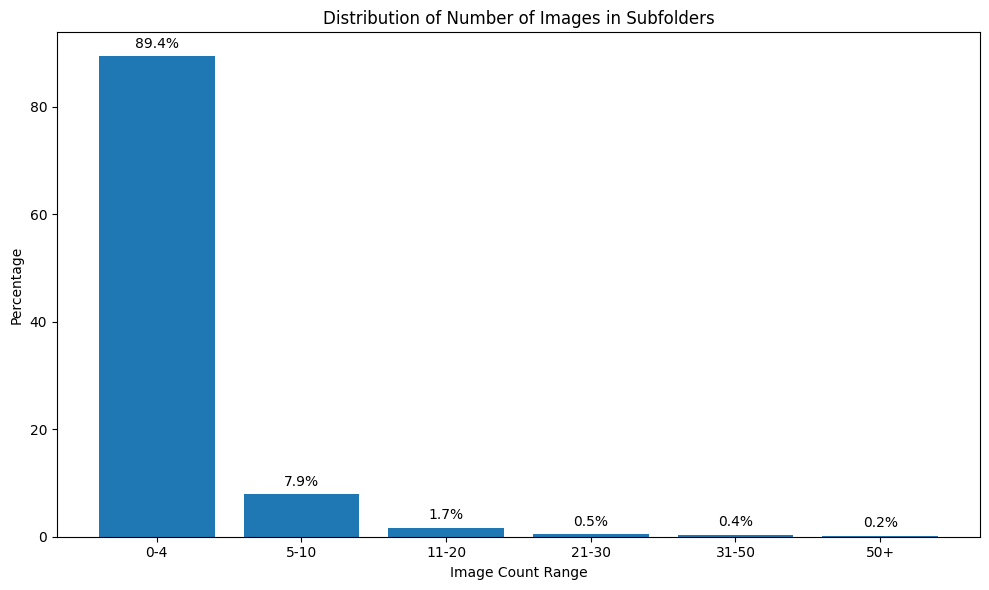

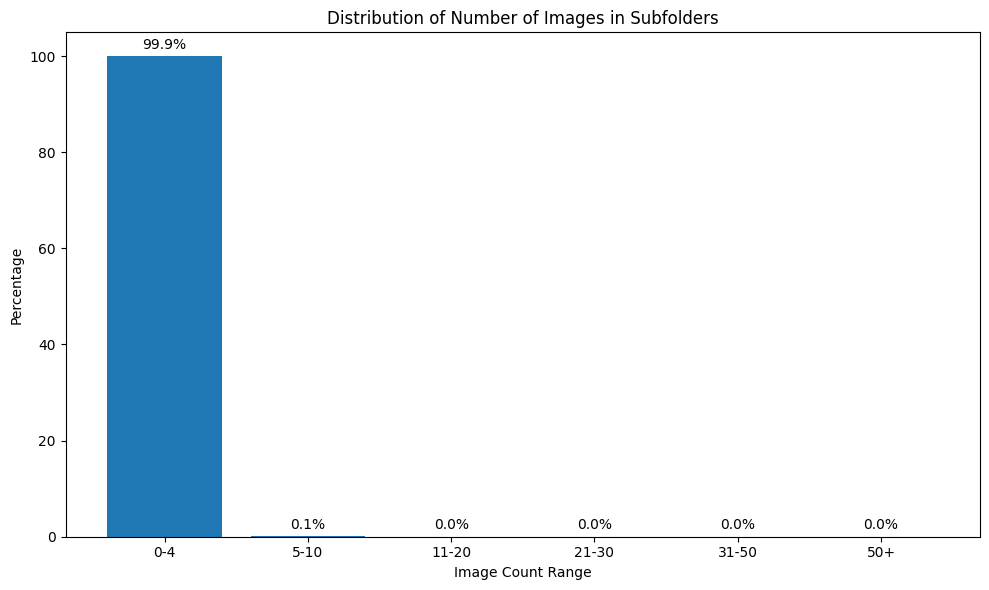

In [ ]:
plot_histogram(DRIVE_FOLDER_PATH)
plot_histogram(FACES_FOLDER_PATH)

In [ ]:
#--- OK ---

#Count the number of subfolders in DRIVE_FOLDER_PATH
subfolder_count = len([name for name in os.listdir(DRIVE_FOLDER_PATH) if os.path.isdir(os.path.join(DRIVE_FOLDER_PATH, name))])
print("Number of subfolders:", subfolder_count)

# Images specifics
img_shape = data.shape[1:]
print("Images' shape:", img_shape)
print("Number of images:", len(data))

# print random image
plt.imshow(data[np.random.randint(len(data))], interpolation="none", cmap="gray")

Number of subfolders: 5749
Images' shape: ()
Number of images: 0


ValueError: ignored

#Generator and Discriminator


*   **Activation functions**: either **elu** (Exponential Linear Unit) or **relu** (Rectified Linear Unit).
*   **Kernel sizes**: defines the desired level of details in the generated faces, In a generating GAN, a progressive architecture shall be preferred. Going from 5x5 to 3x3 helps the model capture broader features first and finer details later.
*   **Number of filters**: opposite to Kernel size, the number of filter should increase in order to start by capturing less details first and more later on. A high number of filters may require more training data. The final layer should have as many filters as there are channels in the output images (3 for RGB images).





In [ ]:
# --- Models ---

# Model generator to produce synthetic data from a random noise vector
def generator(noise_vector_size=256):
  model = keras.Sequential()
  # Noise vector used as seed for generating synthetic data
  model.add(layers.Input(shape=(noise_vector_size,), name='code'))
  # Take the random noise vector and apply a non-linear transformation to it, expanding it into a larger tensor
  model.add(layers.Dense(6*6*32, activation='elu'))
  # This layer reshapes the tensor from the previous dense layer into a 3D tensor with dimensions (6, 6, 32).
  # This tensor serves as a feature map
  model.add(layers.Reshape((6,6,32)))
  # Transposed convolution to upsample the feature map (decreasing the filter number)
  model.add(layers.Conv2DTranspose(128, kernel_size=5, activation='elu'))
  model.add(layers.Conv2DTranspose(128, kernel_size=3, activation='elu'))
  model.add(layers.Conv2DTranspose(64, kernel_size=3, activation='elu'))
  # This layer performs upsampling by duplicating the data in both the vertical and horizontal dimensions. It increases the spatial resolution
  model.add(layers.UpSampling2D())
  # Transposed convolution to upsample the feature map (decreasing the filter number)
  model.add(layers.Conv2DTranspose(64, kernel_size=3, activation='elu'))
  model.add(layers.Conv2DTranspose(32, kernel_size=3, activation='elu'))
  model.add(layers.Conv2DTranspose(32, kernel_size=3, activation='elu'))
  model.add(layers.Conv2DTranspose(3, kernel_size=3))
  return model

# Model discriminator
def discriminator(img_shape):
  model = keras.Sequential()
  model.add(layers.Input(shape=img_shape, name="image"))
  model.add(layers.Conv2D(32, kernel_size=3, activation='elu'))
  model.add(layers.Conv2D(32, kernel_size=5, activation='elu'))
  model.add(layers.Conv2D(64, kernel_size=3, activation='elu'))
  model.add(layers.MaxPool2D())
  model.add(layers.Conv2D(64, kernel_size=3, activation='elu'))
  model.add(layers.Conv2D(128, kernel_size=5, activation='elu'))
  model.add(layers.Conv2D(128, kernel_size=3, activation='elu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.l2()))
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

# Generator and Discriminator with Batch Normalization

In [ ]:
# --- Models with Batch Normalization ---

# Model generator to produce synthetic data from a random noise vector
def generator(noise_vector_size=256):
  model = keras.Sequential()
  model.add(layers.Input(shape=(noise_vector_size,), name='code'))
  model.add(layers.Dense(6*6*32, activation='elu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Reshape((6,6,32)))
  model.add(layers.Conv2DTranspose(128, kernel_size=5, activation='elu'))
  model.add(layers.Conv2DTranspose(128, kernel_size=3, activation='elu'))
  model.add(layers.Conv2DTranspose(64, kernel_size=3, activation='elu'))
  model.add(layers.BatchNormalization())
  model.add(layers.UpSampling2D())
  model.add(layers.Conv2DTranspose(64, kernel_size=3, activation='elu'))
  model.add(layers.Conv2DTranspose(32, kernel_size=3, activation='elu'))
  model.add(layers.Conv2DTranspose(32, kernel_size=3, activation='elu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2DTranspose(3, kernel_size=3))
  return model

# Model discriminator
def discriminator(img_shape):
  model = keras.Sequential()
  model.add(layers.Input(shape=img_shape, name="image"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, kernel_size=3, activation='elu'))
  model.add(layers.Conv2D(32, kernel_size=5, activation='elu'))
  model.add(layers.Conv2D(64, kernel_size=3, activation='elu'))
  model.add(layers.MaxPool2D())
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, kernel_size=3, activation='elu'))
  model.add(layers.Conv2D(128, kernel_size=5, activation='elu'))
  model.add(layers.Conv2D(128, kernel_size=3, activation='elu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.l2()))
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

# Model training

In [ ]:
# Clear the current TensorFlow session and reset the computational graph.
# Release the memory used by the previous TensorFlow session and allows
# to start with a clean slate for building and training new models.
keras.backend.clear_session()

# noise_vector_size is a constant that represents the dimensionality (size) of
# the random noise vector or code that is input to the generator network in a
# Generative Adversarial Network (GAN)
noise_vector_size = 256
gen = generator(noise_vector_size=noise_vector_size)
gen.summary()
print("Inputs :", gen.inputs)
print("Outputs:", gen.outputs)

disc = discriminator(img_shape)
disc.summary()
print("Inputs :", disc.inputs)
print("Outputs:", disc.outputs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1152)              296064    
                                                                 
 batch_normalization (Batch  (None, 1152)              4608      
 Normalization)                                                  
                                                                 
 reshape (Reshape)           (None, 6, 6, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 10, 10, 128)       102528    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 12, 12, 128)       147584    
 Transpose)                                                      
                                                        

Epoch: 9900
1/1 [==============================] - 0s 18ms/step


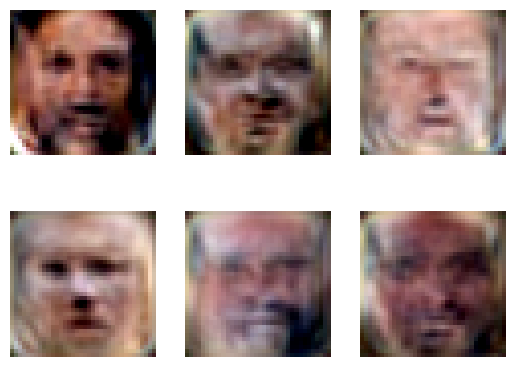

Epoch: 9901, Discriminator Loss: 0.1087912768125534, Generator Loss: 4.926612377166748
Epoch: 9902, Discriminator Loss: 0.15232966840267181, Generator Loss: 4.162501811981201
Epoch: 9903, Discriminator Loss: 0.13171808421611786, Generator Loss: 4.509922981262207
Epoch: 9904, Discriminator Loss: 0.1195572018623352, Generator Loss: 3.955491304397583
Epoch: 9905, Discriminator Loss: 0.2721337080001831, Generator Loss: 5.0334625244140625
Epoch: 9906, Discriminator Loss: 0.28762930631637573, Generator Loss: 3.2075917720794678
Epoch: 9907, Discriminator Loss: 0.3823377192020416, Generator Loss: 5.31223201751709
Epoch: 9908, Discriminator Loss: 0.30964338779449463, Generator Loss: 3.9292104244232178
Epoch: 9909, Discriminator Loss: 0.13398122787475586, Generator Loss: 4.027865886688232
Epoch: 9910, Discriminator Loss: 0.1443401724100113, Generator Loss: 4.070679664611816
Epoch: 9911, Discriminator Loss: 0.15137572586536407, Generator Loss: 4.383695602416992
Epoch: 9912, Discriminator Loss: 0.

Epoch: 9999, Discriminator Loss: 0.10468018054962158, Generator Loss: 4.106771469116211


In [ ]:
epoch = tf.Variable(0)
# This line creates a Stochastic Gradient Descent (SGD) optimizer with a learning rate of 1e-3.
# This optimizer is used for updating the weights of the discriminator model
disc_opt = optimizers.SGD(1e-3)
gen_opt = optimizers.Adam(1e-4)

# Define the directory to save checkpoints
checkpoint_dir = "/content/drive/MyDrive/GAN_model_data/checkpoint/"

# Define a checkpoint callback to save the models at a specified interval
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(checkpoint_dir, "generator_weights.h5"),  # Path to save the generator weights
    save_best_only=False,  # Set to True to save only the best models
    save_freq=1000,  # Save every 1000 epochs
)

checkpoint_callback_disc = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(checkpoint_dir, "discriminator_weights.h5"),  # Path to save the discriminator weights
    save_best_only=False,  # Set to True to save only the best models
    save_freq=1000,  # Save every 1000 epochs
)
# Initialize lists to store loss values
disc_loss_values = []
gen_loss_values = []

for _ in range(10000):
    noise = np.float32(np.random.normal(size=(100, noise_vector_size)))
    images = data[np.random.choice(len(data), size=100)]

    disc_losses = []
    gen_losses = []

    # by looping on the discriminator training, the code minimizes multiple times the discriminator loss function
    # this can help stabilize the GAN training
    for n in range(5):
        d_loss_value = -tf.math.reduce_mean(tf.math.log(disc(images)) + tf.math.log(1-disc(gen(noise))))
        disc_losses.append(d_loss_value.numpy())
        # minimize the loss functions associated with the discriminator
        disc_opt.minimize(lambda: -tf.math.reduce_mean(tf.math.log(disc(images)) + tf.math.log(1-disc(gen(noise)))), disc.trainable_weights)

    g_loss_value = -tf.math.reduce_mean(tf.math.log(disc(gen(noise))))
    gen_losses.append(g_loss_value.numpy())
    # minimize the loss functions associated with the generator
    gen_opt.minimize(lambda: -tf.math.reduce_mean(tf.math.log(disc(gen(noise)))), gen.trainable_weights)

    avg_disc_loss = np.mean(disc_losses)
    avg_gen_loss = np.mean(gen_losses)
    # Append loss values to lists
    disc_loss_values.append(avg_disc_loss)
    gen_loss_values.append(avg_gen_loss)

    print(f"Epoch: {epoch.numpy()}, Discriminator Loss: {avg_disc_loss}, Generator Loss: {avg_gen_loss}")

    if epoch.numpy() % 100 == 0:
        display.clear_output(wait=True)

        print("Epoch:", epoch.numpy())

        # Print 2*3 tables with generated images
        preds = gen.predict(np.float32(np.random.normal(size=(2*3, noise_vector_size))))
        for i in range(2 * 3):
            plt.subplot(2, 3, i + 1)
            plt.imshow(preds[i].clip(0., 1.), interpolation="none")
            plt.axis("off")
        plt.show()

    epoch.assign_add(1)

    # Save the generator weights at specified intervals using the checkpoint callback
    if epoch.numpy() % 1000== 0:
        gen.save_weights(os.path.join(checkpoint_dir, f"generator_weights_epoch_{epoch.numpy()}.h5"))
        disc.save_weights(os.path.join(checkpoint_dir, f"discriminator_weights_epoch_{epoch.numpy()}.h5"))

# Convert the lists to a numpy array
loss_data = np.array([disc_loss_values, gen_loss_values])
# Transpose the array to have epochs in rows and losses in columns
loss_data = loss_data.T
# Create a header with column names
header = ["Discriminator Loss", "Generator Loss"]
# Save the loss values to a CSV file with headers
np.savetxt("/content/drive/MyDrive/GAN_model_data/loss_values_FD_BN.csv", loss_data, delimiter=",", header=",".join(header), comments='')


# After training, you can save the final generator model if needed
gen.save("/content/drive/MyDrive/GAN_model_data/FD_gen_model_BN.h5")
disc.save("/content/drive/MyDrive/GAN_model_data/FD_disc_model_BN.h5")

Results after 10000 epochs:
4/4 [==============================] - 0s 4ms/step


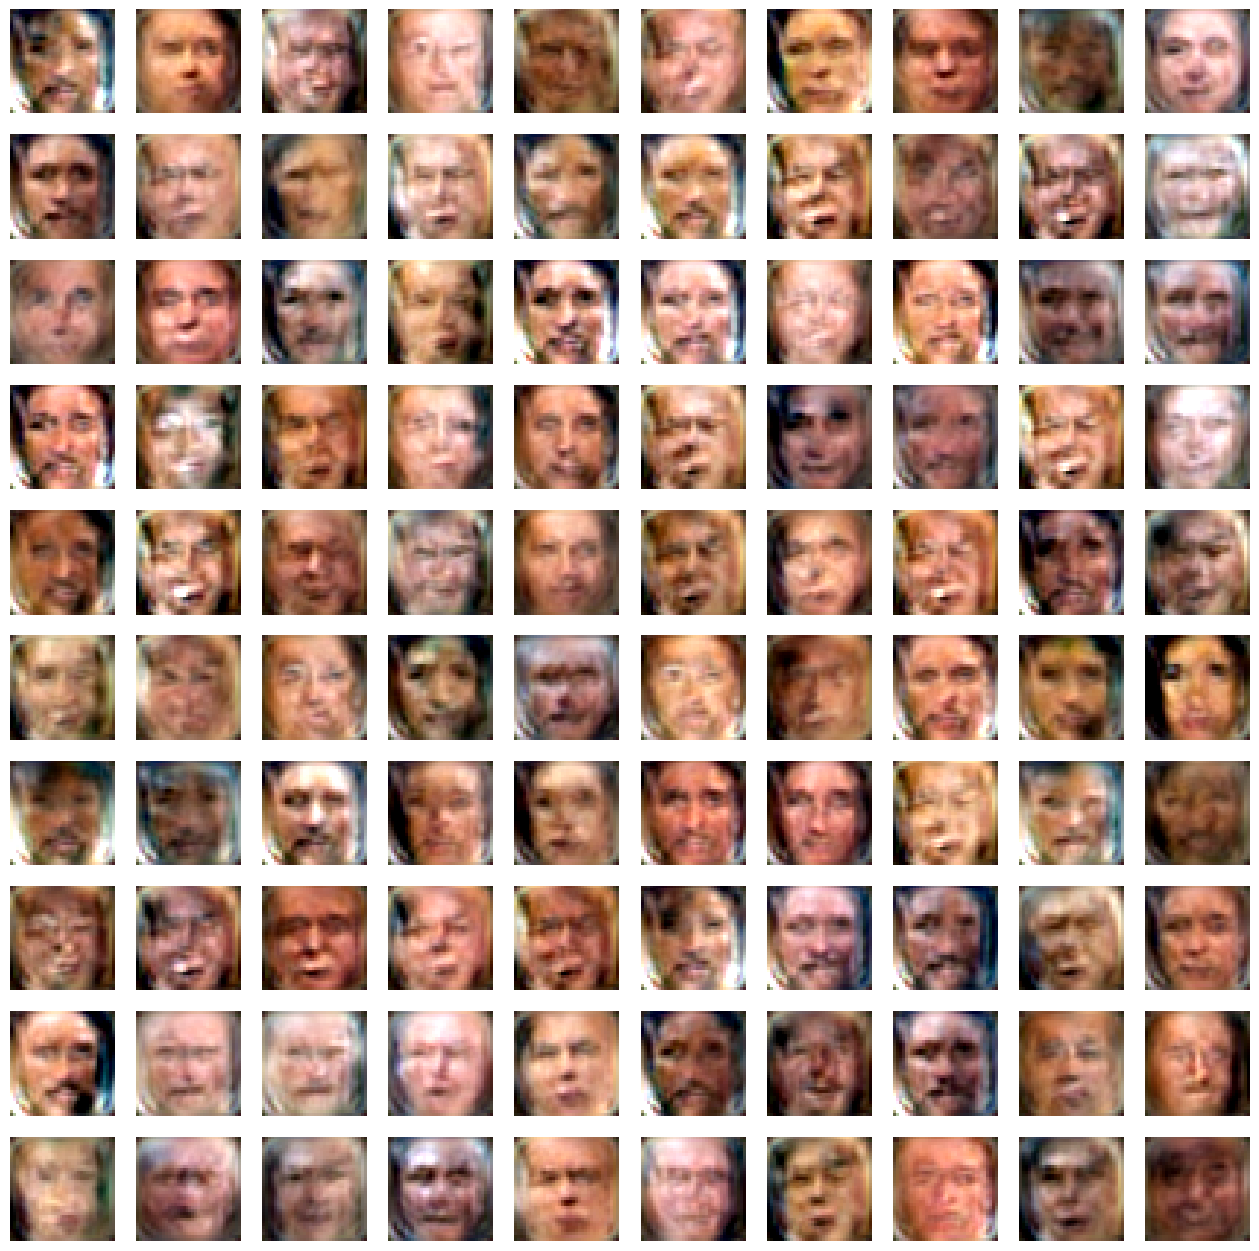

In [ ]:
print("Results after", epoch.numpy(), "epochs:")
plt.figure(figsize=[16, 16])
preds = gen.predict(np.float32(np.random.normal(size=(10*10, noise_vector_size))))

for i in range(10 * 10):
    plt.subplot(10, 10, i + 1)
    plt.imshow(preds[i].clip(0., 1.), interpolation="none")
    plt.axis("off")
plt.show()

#Results

Loss functions

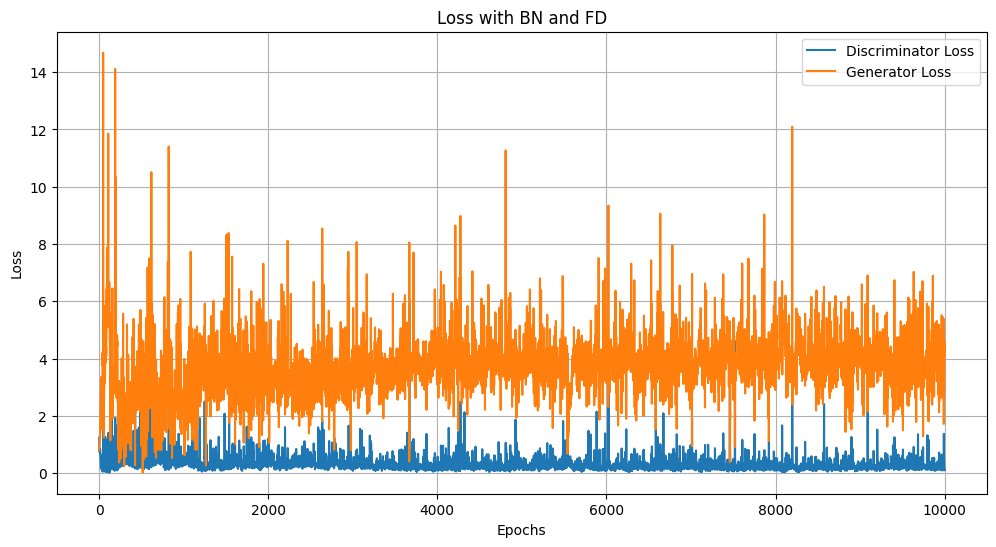

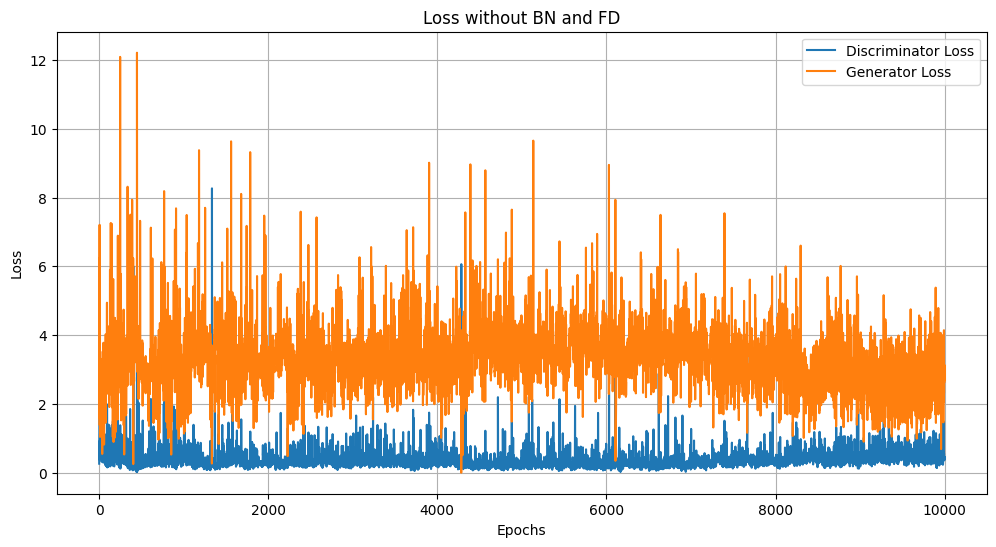

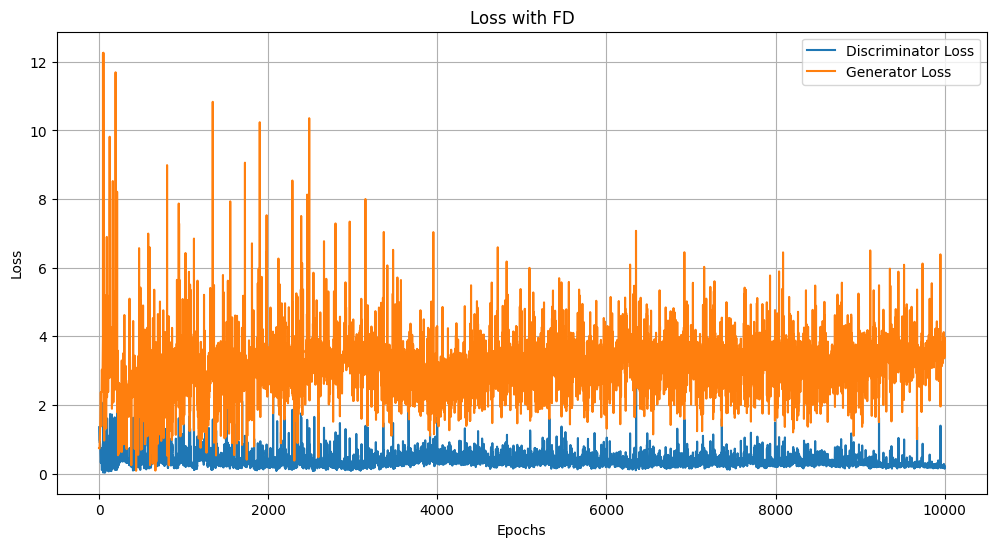

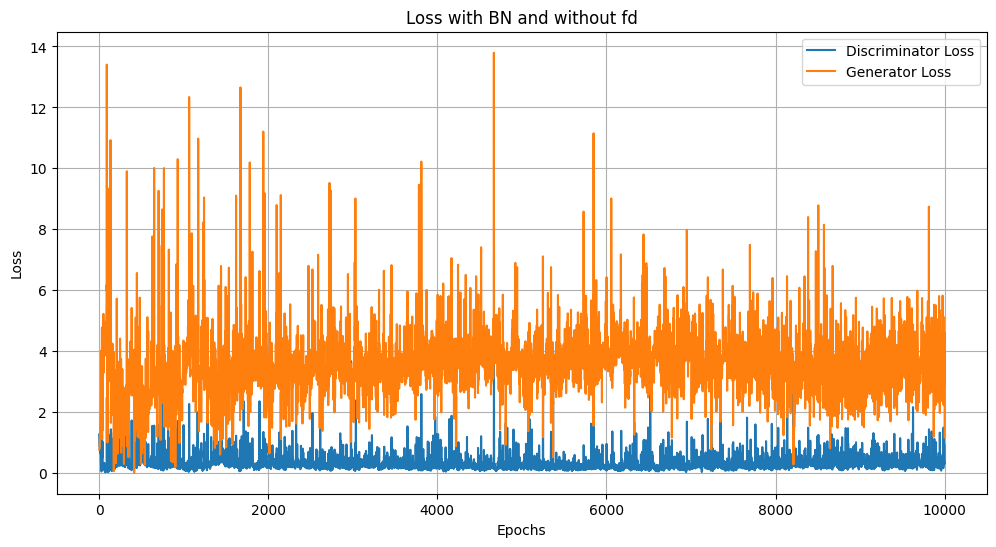

In [ ]:
def plot_loss_from_csv(csv_file_path, title):
    # Load the loss data from the CSV file
    loss_data = np.genfromtxt(csv_file_path, delimiter=',', names=True)
    discriminator_loss = loss_data['Discriminator_Loss']
    generator_loss = loss_data['Generator_Loss']

    # Create an array of epoch numbers
    epochs = np.arange(1, len(discriminator_loss) + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, discriminator_loss, label='Discriminator Loss', linestyle='-')
    plt.plot(epochs, generator_loss, label='Generator Loss', linestyle='-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the paths to the CSV files and titles
csv_files = [
    ('/content/drive/MyDrive/GAN_model_data/loss_values/loss_values_FD_BN.csv', 'Loss with BN and FD'),
    ('/content/drive/MyDrive/GAN_model_data/loss_values/loss_values_no_bn_no_fd.csv', 'Loss without BN and FD'),
    ('/content/drive/MyDrive/GAN_model_data/loss_values/loss_values_FD.csv', 'Loss with FD'),
    ('/content/drive/MyDrive/GAN_model_data/loss_values/loss_values_bn_no_fd.csv', 'Loss with BN and without fd')
]

# Plot loss values for each CSV file
for csv_file, title in csv_files:
    plot_loss_from_csv(csv_file, title)

Images

1/1 [==============================] - 0s 206ms/step


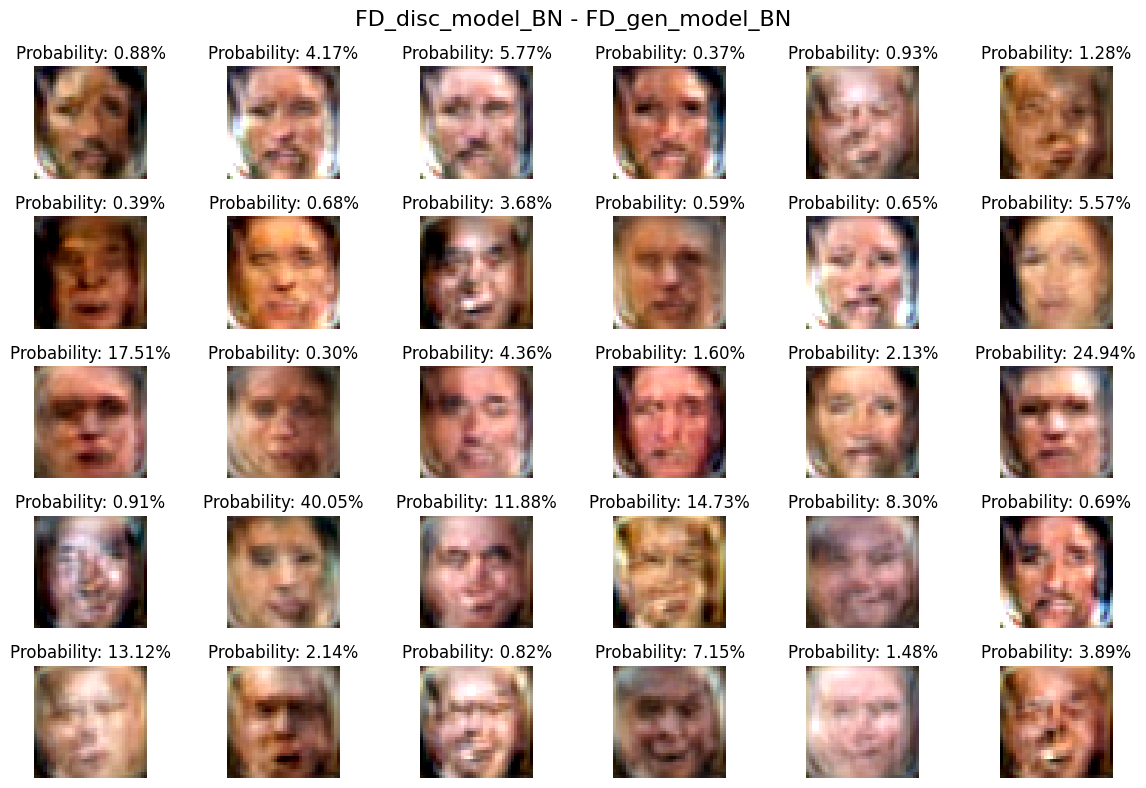

1/1 [==============================] - 0s 85ms/step


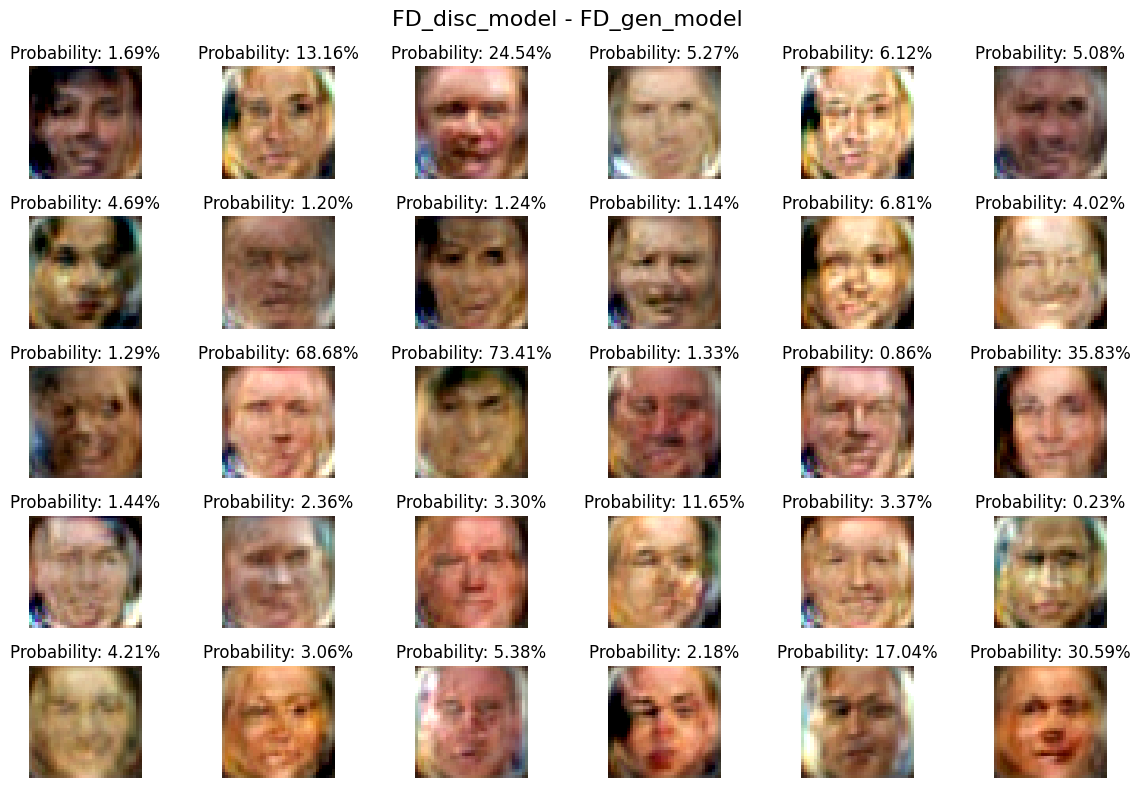

1/1 [==============================] - 0s 146ms/step


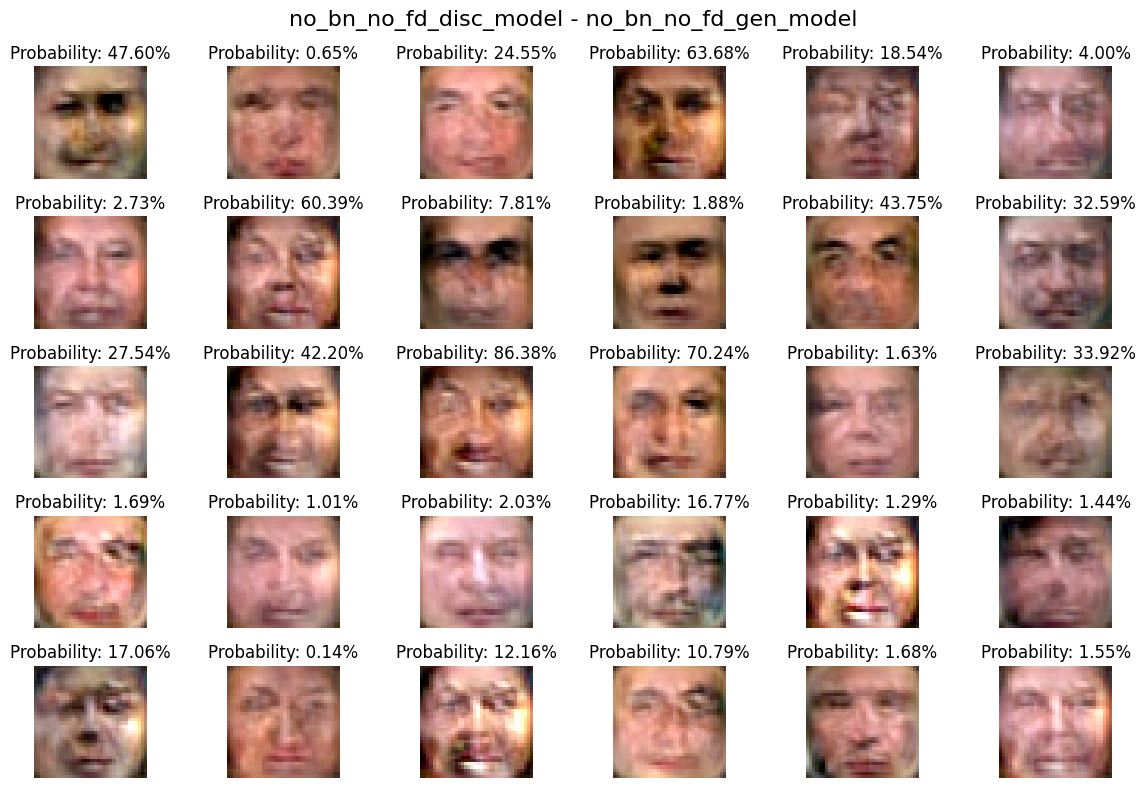

1/1 [==============================] - 0s 110ms/step


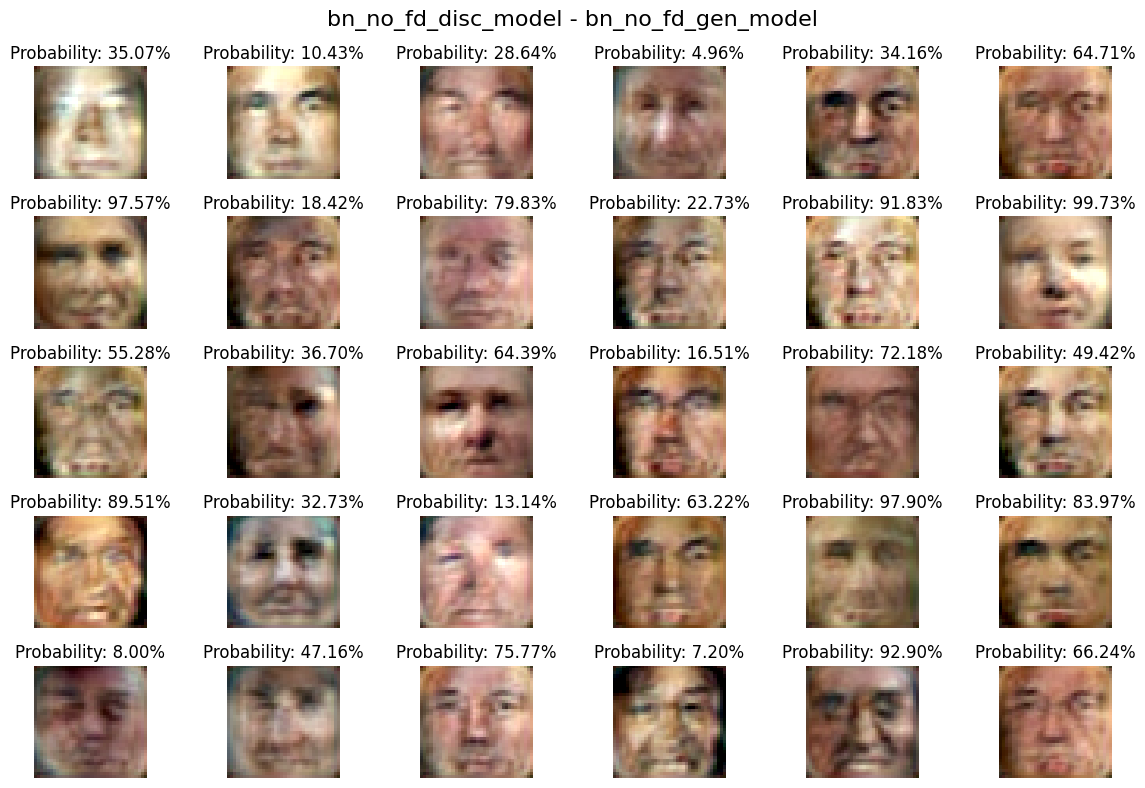

In [ ]:
# Define the list of model paths with their names
model_paths = [
    ("/content/drive/MyDrive/GAN_model_data/models/FD_disc_model_BN.h5", "FD_disc_model_BN", "/content/drive/MyDrive/GAN_model_data/models/FD_gen_model_BN.h5", "FD_gen_model_BN"),
    ("/content/drive/MyDrive/GAN_model_data/models/FD_disc_model.h5", "FD_disc_model", "/content/drive/MyDrive/GAN_model_data/models/FD_gen_model.h5", "FD_gen_model"),
    ("/content/drive/MyDrive/GAN_model_data/models/no_bn_no_fd_disc_model.h5", "no_bn_no_fd_disc_model", "/content/drive/MyDrive/GAN_model_data/models/no_bn_no_fd_gen_model.h5", "no_bn_no_fd_gen_model"),
    ("/content/drive/MyDrive/GAN_model_data/models/bn_no_fd_disc_model.h5", "bn_no_fd_disc_model", "/content/drive/MyDrive/GAN_model_data/models/bn_no_fd_gen_model.h5", "bn_no_fd_gen_model")
]

# Define the number of images to generate
num_images_to_generate = 30
# Define the noise vector size (make sure it matches your generator's noise vector size)
noise_vector_size = 256

# Create a loop to load models and generate images with probabilities
for disc_model_path, disc_model_name, gen_model_path, gen_model_name in model_paths:
    # Load the discriminator model and the generator model
    loaded_discriminator = keras.models.load_model(disc_model_path)
    loaded_generator = keras.models.load_model(gen_model_path)

    # Generate random noise vectors
    noise = np.float32(np.random.normal(size=(num_images_to_generate, noise_vector_size)))

    # Generate synthetic images using the generator
    generated_images = loaded_generator.predict(noise)

    # Calculate the probabilities using the discriminator model
    probas_generated = loaded_discriminator.predict(generated_images)

    # Display the generated images with their probabilities and titles
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"{disc_model_name} - {gen_model_name}", fontsize=16)

    for i in range(num_images_to_generate):
        plt.subplot(5, 6, i + 1)
        plt.imshow(generated_images[i].clip(0., 1.), interpolation="none")
        plt.title(f'Probability: {probas_generated[i][0] * 100:.2f}%')
        plt.axis("off")

    plt.tight_layout()
    plt.show()